Training the model...

Evaluation Metrics:
Mean Squared Error: 12.7763703088193
Mean Absolute Error: 2.781157427857937
R-squared: 0.17147602408447893


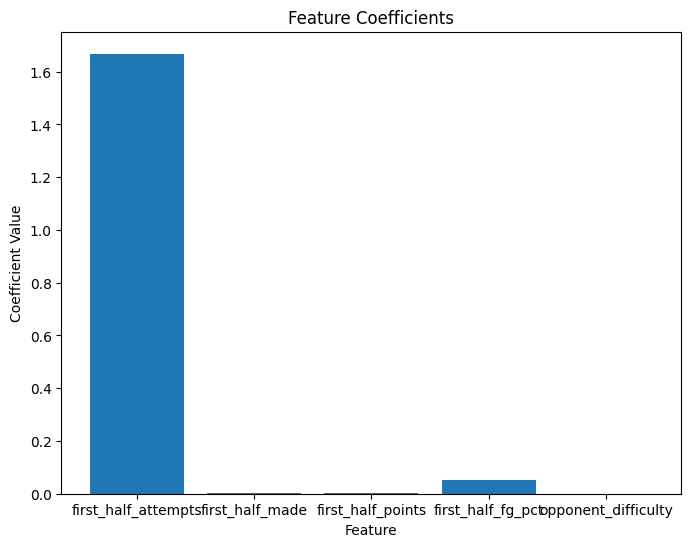


Model and scaler saved as 'player_performance_predictor.pkl' and 'scaler.pkl' respectively.
Predicted second-half points for lebron James: 7.27


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # Updated import
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import os

def train_model():
    # Load your NBA shot dataset
    nba_df = pd.read_csv('23-24 NBA dataset.csv')
    
    # Verify required columns exist
    required_cols = ['GAME_ID', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'SHOT_TYPE',
                     'PLAYER_NAME', 'TEAM_NAME', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']
    missing_cols = [col for col in required_cols if col not in nba_df.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
        return
    
    # Convert columns to appropriate types
    nba_df['SHOT_ATTEMPTED_FLAG'] = nba_df['SHOT_ATTEMPTED_FLAG'].astype(int)
    nba_df['SHOT_MADE_FLAG'] = nba_df['SHOT_MADE_FLAG'].astype(int)
    nba_df['SHOT_TYPE'] = nba_df['SHOT_TYPE'].astype(str)
    nba_df['PLAYER_NAME'] = nba_df['PLAYER_NAME'].astype(str)
    nba_df['TEAM_NAME'] = nba_df['TEAM_NAME'].astype(str)
    nba_df['HOME_TEAM_NAME'] = nba_df['HOME_TEAM_NAME'].astype(str)
    nba_df['AWAY_TEAM_NAME'] = nba_df['AWAY_TEAM_NAME'].astype(str)
    
    # Determine the opponent team based on home/away info
    def determine_opponent(row):
        if row['TEAM_NAME'] == row['HOME_TEAM_NAME']:
            return row['AWAY_TEAM_NAME']
        else:
            return row['HOME_TEAM_NAME']
    
    nba_df['OPPONENT_TEAM'] = nba_df.apply(determine_opponent, axis=1)
    
    # Filter to shot attempts only
    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG'] == 1].copy()
    
    # Calculate points for each shot:
    def calculate_points(row):
        if row['SHOT_MADE_FLAG'] == 1:
            return 3 if row['SHOT_TYPE'] == '3PT' else 2
        return 0
    shots['POINTS'] = shots.apply(calculate_points, axis=1)
    
    # Aggregate data by GAME_ID, PLAYER_NAME, TEAM_NAME, OPPONENT_TEAM, and PERIOD
    grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM', 'PERIOD']).agg(
        attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
        made=('SHOT_MADE_FLAG', 'sum'),
        points=('POINTS', 'sum')
    ).reset_index()
    
    # Separate first-half (periods 1 & 2) and second-half (periods 3 & 4) data
    first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(
        ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('attempts', 'sum'),
        first_half_made=('made', 'sum'),
        first_half_points=('points', 'sum')
    ).reset_index()
    
    second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(
        ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM']
    ).agg(
        second_half_points=('points', 'sum')
    ).reset_index()
    
    # Merge first and second half data on game, player, team and opponent
    game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM'], how='inner')
    
    # Calculate first-half field goal percentage
    game_player_data['first_half_fg_pct'] = game_player_data.apply(
        lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
        axis=1
    )
    
    # ----------------------------
    # Incorporate Opponent Rankings from the CSV File
    # ----------------------------
    ranking_df = pd.read_csv('23-24 NBA RANKING.csv')
    game_player_data = pd.merge(game_player_data, ranking_df, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left')
    game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(lambda x: 1/x if x > 0 else 0)
    
    # Define features (X) and target (y)
    X = game_player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct', 'opponent_difficulty']]
    y = game_player_data['second_half_points']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a Linear Regression model instead of Random Forest
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
    
    # (Optional) Visualize feature coefficients instead of importances
    coefficients = model.coef_
    plt.figure(figsize=(8, 6))
    plt.bar(X.columns, coefficients)
    plt.title("Feature Coefficients")
    plt.xlabel("Feature")
    plt.ylabel("Coefficient Value")
    plt.show()
    
    # Save the model and scaler
    joblib.dump(model, 'player_performance_predictor.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("\nModel and scaler saved as 'player_performance_predictor.pkl' and 'scaler.pkl' respectively.")

def predict_player_performance(player_name):
    # Ensure model and scaler files exist
    if not os.path.exists('player_performance_predictor.pkl') or not os.path.exists('scaler.pkl'):
        print("Model or scaler file does not exist. Please train the model first.")
        return
    
    model = joblib.load('player_performance_predictor.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # Reload and preprocess the NBA dataset
    nba_df = pd.read_csv('23-24 NBA dataset.csv')
    nba_df['SHOT_ATTEMPTED_FLAG'] = nba_df['SHOT_ATTEMPTED_FLAG'].astype(int)
    nba_df['SHOT_MADE_FLAG'] = nba_df['SHOT_MADE_FLAG'].astype(int)
    nba_df['SHOT_TYPE'] = nba_df['SHOT_TYPE'].astype(str)
    nba_df['PLAYER_NAME'] = nba_df['PLAYER_NAME'].astype(str)
    nba_df['TEAM_NAME'] = nba_df['TEAM_NAME'].astype(str)
    nba_df['HOME_TEAM_NAME'] = nba_df['HOME_TEAM_NAME'].astype(str)
    nba_df['AWAY_TEAM_NAME'] = nba_df['AWAY_TEAM_NAME'].astype(str)
    
    # Determine the opponent team as before
    def determine_opponent(row):
        if row['TEAM_NAME'] == row['HOME_TEAM_NAME']:
            return row['AWAY_TEAM_NAME']
        else:
            return row['HOME_TEAM_NAME']
    
    nba_df['OPPONENT_TEAM'] = nba_df.apply(determine_opponent, axis=1)
    
    # Filter to shot attempts
    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG'] == 1].copy()
    def calculate_points(row):
        if row['SHOT_MADE_FLAG'] == 1:
            return 3 if row['SHOT_TYPE'] == '3PT' else 2
        return 0
    shots['POINTS'] = shots.apply(calculate_points, axis=1)
    
    # Aggregate data
    grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM', 'PERIOD']).agg(
        attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
        made=('SHOT_MADE_FLAG', 'sum'),
        points=('POINTS', 'sum')
    ).reset_index()
    
    first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(
        ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('attempts', 'sum'),
        first_half_made=('made', 'sum'),
        first_half_points=('points', 'sum')
    ).reset_index()
    
    second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(
        ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM']
    ).agg(
        second_half_points=('points', 'sum')
    ).reset_index()
    
    game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM'], how='inner')
    game_player_data['first_half_fg_pct'] = game_player_data.apply(
        lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
        axis=1
    )
    
    # Merge opponent ranking data
    ranking_df = pd.read_csv('23-24 NBA RANKING.csv')
    game_player_data = pd.merge(game_player_data, ranking_df, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left')
    game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(lambda x: 1/x if x > 0 else 0)
    
    # Filter for the specified player (case insensitive)
    player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name.upper()]
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return
    
    # For prediction, use the features from the first matching game (or average over games)
    # Use .iloc[[0]] to preserve DataFrame column names
    features = player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct', 'opponent_difficulty']].iloc[[0]]
    features_scaled = scaler.transform(features)
    prediction = model.predict(features_scaled)
    print(f"Predicted second-half points for {player_name}: {prediction[0]:.2f}")

def main():
    print("Training the model...")
    train_model()
    player_name = input("Enter Player Name: ")
    if player_name.strip():
        predict_player_performance(player_name)
    else:
        print("Please enter a valid player name.")

if __name__ == "__main__":
    main()


In [7]:
#What are the team's overall ranks based on the amount of wins and losses?


                 TEAM_NAME  OVR_RANK
1           Boston Celtics         1
20   Oklahoma City Thunder         2
7           Denver Nuggets         3
17  Minnesota Timberwolves         4
12    Los Angeles Clippers         5
6         Dallas Mavericks         6
19         New York Knicks         7
16         Milwaukee Bucks         8
18    New Orleans Pelicans         9
23            Pheonix Suns        10
5      Cleveland Cavaliers        11
21           Orlando Magic        12
13      Los Angeles Lakers        13
22      Philadelphia 76ers        14
11          Indiana Pacers        15
15              Miami Heat        16
25        Sacramento Kings        17
9    Golden State Warriors        18
10         Houston Rockets        19
4            Chicago Bulls        20
0            Atlanta Hawks        21
2            Brooklyn Nets        22
28               Utah Jazz        23
14       Memphis Grizzlies        24
27         Toronto Raptors        25
26       San Antonio Spurs        26
3

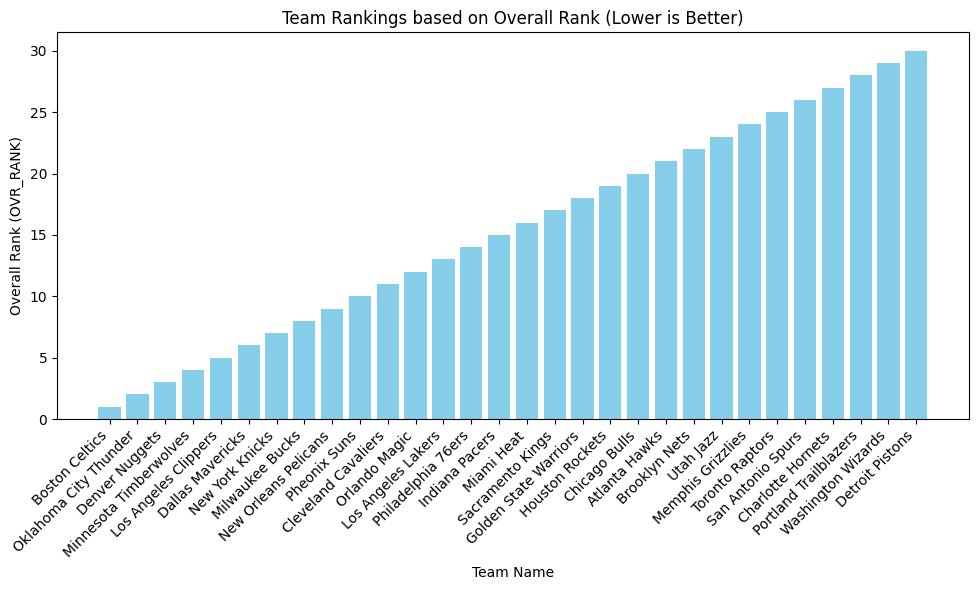

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file once
df = pd.read_csv('23-24 NBA RANKING.csv')

# Sort the dataframe by OVR_RANK
df_sorted = df.sort_values(by='OVR_RANK', ascending=True)

# Display the sorted team names and overall ranks
print(df_sorted[['TEAM_NAME', 'OVR_RANK']])

# Visualize the rankings with a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['TEAM_NAME'], df_sorted['OVR_RANK'], color='skyblue')
plt.xlabel('Team Name')
plt.ylabel('Overall Rank (OVR_RANK)')
plt.title('Team Rankings based on Overall Rank (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# What is the predicted output of a player based on the matchup and rankings of their opponent?

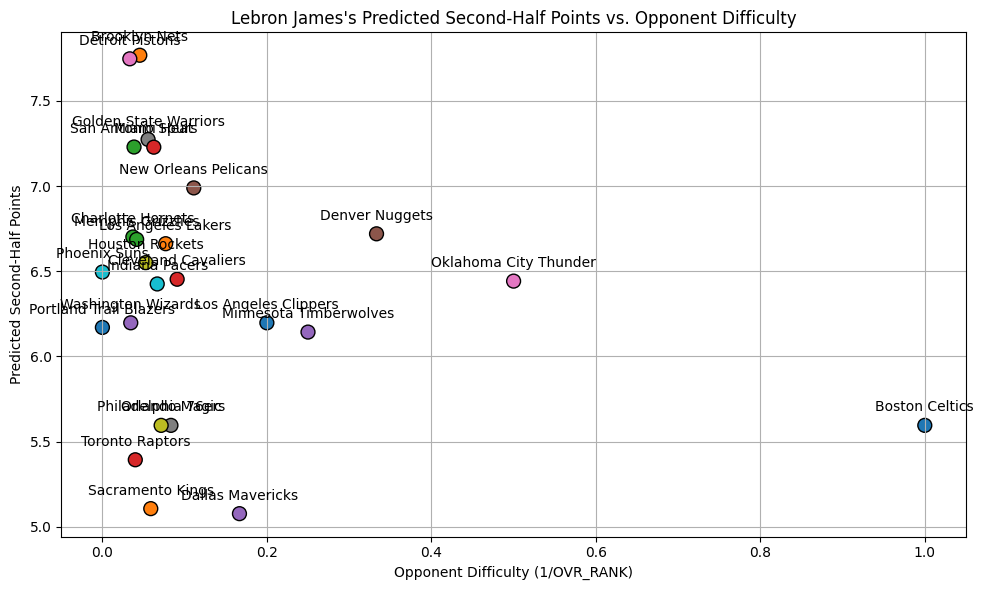

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# ----------------------------
# Define a mapping from abbreviated team names to full team names
# (Modify this dictionary if your abbreviations or full names differ.)
team_name_map = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BKN": "Brooklyn Nets",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

# ----------------------------
# Load the trained model and scaler
# ----------------------------
if not os.path.exists('player_performance_predictor.pkl') or not os.path.exists('scaler.pkl'):
    print("Model or scaler file does not exist. Please train the model first.")
    exit()

model = joblib.load('player_performance_predictor.pkl')
scaler = joblib.load('scaler.pkl')

# ----------------------------
# Load and preprocess the NBA shot dataset
# ----------------------------
nba_df = pd.read_csv('23-24 NBA dataset.csv')

# Convert columns to appropriate types
nba_df['SHOT_ATTEMPTED_FLAG'] = nba_df['SHOT_ATTEMPTED_FLAG'].astype(int)
nba_df['SHOT_MADE_FLAG'] = nba_df['SHOT_MADE_FLAG'].astype(int)
nba_df['SHOT_TYPE'] = nba_df['SHOT_TYPE'].astype(str)
nba_df['PLAYER_NAME'] = nba_df['PLAYER_NAME'].astype(str)
nba_df['TEAM_NAME'] = nba_df['TEAM_NAME'].astype(str)
nba_df['HOME_TEAM_NAME'] = nba_df['HOME_TEAM_NAME'].astype(str)
nba_df['AWAY_TEAM_NAME'] = nba_df['AWAY_TEAM_NAME'].astype(str)

# Determine the opponent team based on home/away info
def determine_opponent(row):
    if row['TEAM_NAME'] == row['HOME_TEAM_NAME']:
        return row['AWAY_TEAM_NAME']
    else:
        return row['HOME_TEAM_NAME']

nba_df['OPPONENT_TEAM'] = nba_df.apply(determine_opponent, axis=1)
nba_df['OPPONENT_TEAM'] = nba_df['OPPONENT_TEAM'].str.strip()

# Map abbreviated opponent team names to full names
nba_df['OPPONENT_TEAM_FULL'] = nba_df['OPPONENT_TEAM'].apply(lambda x: team_name_map.get(x, x))

# Filter to shot attempts only
shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG'] == 1].copy()

# Calculate points for each shot (3 for 3PT, 2 for other field goals)
def calculate_points(row):
    if row['SHOT_MADE_FLAG'] == 1:
        return 3 if row['SHOT_TYPE'] == '3PT' else 2
    return 0

shots['POINTS'] = shots.apply(calculate_points, axis=1)

# Aggregate data by GAME_ID, PLAYER_NAME, TEAM_NAME, OPPONENT_TEAM_FULL, and PERIOD
grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL', 'PERIOD']).agg(
    attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
    made=('SHOT_MADE_FLAG', 'sum'),
    points=('POINTS', 'sum')
).reset_index()

# Separate first-half (periods 1 & 2) and second-half (periods 3 & 4) data
first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(
    ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL']
).agg(
    first_half_attempts=('attempts', 'sum'),
    first_half_made=('made', 'sum'),
    first_half_points=('points', 'sum')
).reset_index()

second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(
    ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL']
).agg(
    second_half_points=('points', 'sum')
).reset_index()

# Merge first and second half data
game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL'], how='inner')

# Calculate first-half field goal percentage
game_player_data['first_half_fg_pct'] = game_player_data.apply(
    lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
    axis=1
)

# ----------------------------
# Incorporate Opponent Rankings
# ----------------------------
ranking_df = pd.read_csv('23-24 NBA RANKING.csv')
ranking_df['TEAM_NAME'] = ranking_df['TEAM_NAME'].str.strip()  # Clean names in the ranking CSV

# Merge ranking data with game data using the full opponent team names
game_player_data = pd.merge(
    game_player_data,
    ranking_df,
    left_on='OPPONENT_TEAM_FULL',
    right_on='TEAM_NAME',
    how='left'
)

# Compute opponent difficulty: 1/OVR_RANK if OVR_RANK > 0, else 0
game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(lambda x: 1/x if x > 0 else 0)

# ----------------------------
# Prompt the user for a player name
# ----------------------------
player_name_input = input("Enter Player Name: ").strip()
if not player_name_input:
    print("Please enter a valid player name.")
    exit()

# Filter data for the specified player (case insensitive)
player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name_input.upper()]
if player_data.empty:
    print(f"No data found for player: {player_name_input}")
    exit()

# ----------------------------
# Group data by opponent team (each point represents one matchup)
# ----------------------------
# For each opponent team, compute the average first-half features and opponent difficulty
opponent_grouped = player_data.groupby('OPPONENT_TEAM_FULL').agg({
    'first_half_attempts': 'mean',
    'first_half_made': 'mean',
    'first_half_points': 'mean',
    'first_half_fg_pct': 'mean',
    'opponent_difficulty': 'mean',
    'second_half_points': 'mean'  # (Optional) Actual average second-half points for reference
}).reset_index()

# Prepare features for prediction (same order as used in training)
# NOTE: Remove the .values to preserve DataFrame column names.
features = opponent_grouped[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct', 'opponent_difficulty']]
features_scaled = scaler.transform(features)

# Predict second-half points for each opponent matchup
predicted_points = model.predict(features_scaled)
opponent_grouped['predicted_second_half_points'] = predicted_points

# ----------------------------
# Create a scatter plot for the player's predicted second-half points vs. opponent difficulty
# ----------------------------
plt.figure(figsize=(10, 6))
x = opponent_grouped['opponent_difficulty']  # x-axis: Opponent Difficulty (1/OVR_RANK)
y = opponent_grouped['predicted_second_half_points']  # y-axis: Predicted Second-Half Points
teams = opponent_grouped['OPPONENT_TEAM_FULL']

# Generate colors for each point using a colormap
cmap = plt.get_cmap('tab10')
colors = [cmap(i % cmap.N) for i in range(len(opponent_grouped))]

plt.scatter(x, y, c=colors, s=100, edgecolor='black')

# Annotate each point with the opponent team name
for i, team in enumerate(teams):
    plt.annotate(team, (x.iloc[i], y.iloc[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Opponent Difficulty (1/OVR_RANK)')
plt.ylabel('Predicted Second-Half Points')
plt.title(f"{player_name_input}'s Predicted Second-Half Points vs. Opponent Difficulty")
plt.grid(True)
plt.tight_layout()
plt.show()


I want to create a graph that shows the actual and predicted points that a player of my choosing performs based on the matchup and rankings of their opponent?


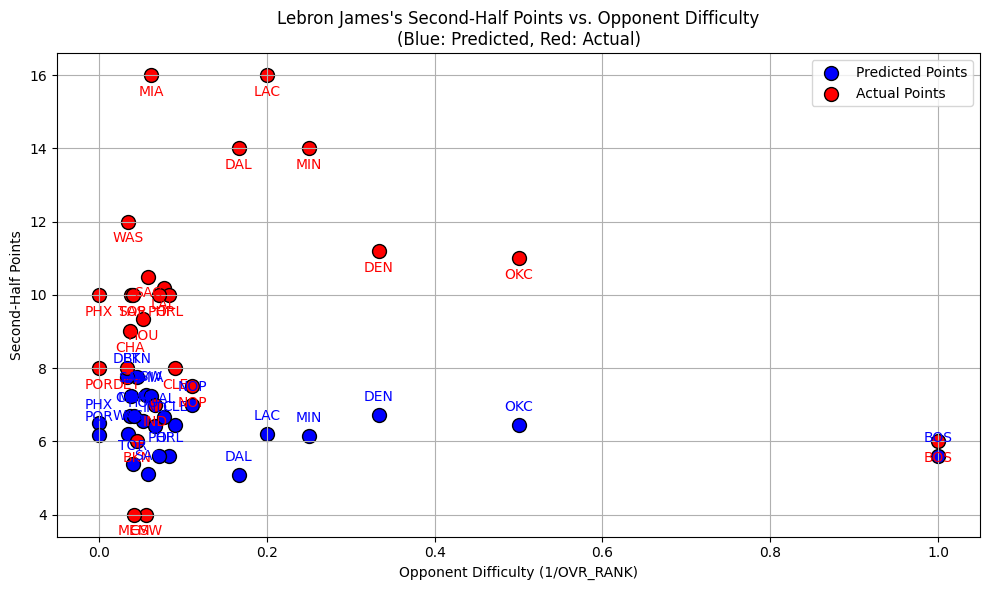

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# ----------------------------
# Define a mapping from abbreviated team names to full team names
# (Modify this dictionary if your abbreviations or full names differ.)
team_name_map = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BKN": "Brooklyn Nets",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

# Create an inverted mapping: full name -> abbreviation
full_to_abbrev = {v: k for k, v in team_name_map.items()}

# ----------------------------
# Load the trained model and scaler
# ----------------------------
if not os.path.exists('player_performance_predictor.pkl') or not os.path.exists('scaler.pkl'):
    print("Model or scaler file does not exist. Please train the model first.")
    exit()

model = joblib.load('player_performance_predictor.pkl')
scaler = joblib.load('scaler.pkl')

# ----------------------------
# Load and preprocess the NBA shot dataset
# ----------------------------
nba_df = pd.read_csv('23-24 NBA dataset.csv')

# Convert columns to appropriate types
nba_df['SHOT_ATTEMPTED_FLAG'] = nba_df['SHOT_ATTEMPTED_FLAG'].astype(int)
nba_df['SHOT_MADE_FLAG'] = nba_df['SHOT_MADE_FLAG'].astype(int)
nba_df['SHOT_TYPE'] = nba_df['SHOT_TYPE'].astype(str)
nba_df['PLAYER_NAME'] = nba_df['PLAYER_NAME'].astype(str)
nba_df['TEAM_NAME'] = nba_df['TEAM_NAME'].astype(str)
nba_df['HOME_TEAM_NAME'] = nba_df['HOME_TEAM_NAME'].astype(str)
nba_df['AWAY_TEAM_NAME'] = nba_df['AWAY_TEAM_NAME'].astype(str)

# Determine the opponent team based on home/away info
def determine_opponent(row):
    if row['TEAM_NAME'] == row['HOME_TEAM_NAME']:
        return row['AWAY_TEAM_NAME']
    else:
        return row['HOME_TEAM_NAME']

nba_df['OPPONENT_TEAM'] = nba_df.apply(determine_opponent, axis=1)
nba_df['OPPONENT_TEAM'] = nba_df['OPPONENT_TEAM'].str.strip()

# Map abbreviated opponent team names to full names
nba_df['OPPONENT_TEAM_FULL'] = nba_df['OPPONENT_TEAM'].apply(lambda x: team_name_map.get(x, x))

# Filter to shot attempts only
shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG'] == 1].copy()

# Calculate points for each shot (3 for 3PT, 2 for others)
def calculate_points(row):
    if row['SHOT_MADE_FLAG'] == 1:
        return 3 if row['SHOT_TYPE'] == '3PT' else 2
    return 0

shots['POINTS'] = shots.apply(calculate_points, axis=1)

# Aggregate data by GAME_ID, PLAYER_NAME, TEAM_NAME, OPPONENT_TEAM_FULL, and PERIOD
grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL', 'PERIOD']).agg(
    attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
    made=('SHOT_MADE_FLAG', 'sum'),
    points=('POINTS', 'sum')
).reset_index()

# Separate first-half (periods 1 & 2) and second-half (periods 3 & 4) data
first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(
    ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL']
).agg(
    first_half_attempts=('attempts', 'sum'),
    first_half_made=('made', 'sum'),
    first_half_points=('points', 'sum')
).reset_index()

second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(
    ['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL']
).agg(
    second_half_points=('points', 'sum')
).reset_index()

# Merge first and second half data
game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME', 'TEAM_NAME', 'OPPONENT_TEAM_FULL'], how='inner')

# Calculate first-half field goal percentage
game_player_data['first_half_fg_pct'] = game_player_data.apply(
    lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
    axis=1
)

# ----------------------------
# Incorporate Opponent Rankings
# ----------------------------
ranking_df = pd.read_csv('23-24 NBA RANKING.csv')
ranking_df['TEAM_NAME'] = ranking_df['TEAM_NAME'].str.strip()  # Clean team names in the ranking CSV

# Merge ranking data with game data using the full opponent team names
game_player_data = pd.merge(
    game_player_data,
    ranking_df,
    left_on='OPPONENT_TEAM_FULL',
    right_on='TEAM_NAME',
    how='left'
)

# Compute opponent difficulty: 1/OVR_RANK if OVR_RANK > 0, else 0
game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(lambda x: 1/x if x > 0 else 0)

# ----------------------------
# Prompt the user for a player name
# ----------------------------
player_name_input = input("Enter Player Name: ").strip()
if not player_name_input:
    print("Please enter a valid player name.")
    exit()

# Filter data for the specified player (case insensitive)
player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name_input.upper()]
if player_data.empty:
    print(f"No data found for player: {player_name_input}")
    exit()

# ----------------------------
# Group data by opponent team so each point represents one matchup
# ----------------------------
# For each opponent team, compute the average first-half features, opponent difficulty,
# and also the average actual second-half points.
opponent_grouped = player_data.groupby('OPPONENT_TEAM_FULL').agg({
    'first_half_attempts': 'mean',
    'first_half_made': 'mean',
    'first_half_points': 'mean',
    'first_half_fg_pct': 'mean',
    'opponent_difficulty': 'mean',
    'second_half_points': 'mean'  # Actual average second-half points
}).reset_index()

# Prepare features for prediction (using the same order as in training)
feature_columns = ['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct', 'opponent_difficulty']
features = opponent_grouped[feature_columns]  # Keep as a DataFrame with column names
features_scaled = scaler.transform(features)

# Predict second-half points for each opponent matchup
predicted_points = model.predict(features_scaled)
opponent_grouped['predicted_second_half_points'] = predicted_points

# ----------------------------
# Create a scatter plot showing both predicted and actual second-half points vs. opponent difficulty
# ----------------------------
plt.figure(figsize=(10, 6))
x = opponent_grouped['opponent_difficulty']

# Plot predicted points (blue) and actual points (red)
plt.scatter(x, opponent_grouped['predicted_second_half_points'], c='blue', s=100, edgecolor='black', label='Predicted Points')
plt.scatter(x, opponent_grouped['second_half_points'], c='red', s=100, edgecolor='black', label='Actual Points')

# Annotate each point with the abbreviated team name
for i, team_full in enumerate(opponent_grouped['OPPONENT_TEAM_FULL']):
    abbrev = full_to_abbrev.get(team_full, team_full)
    # Annotate predicted (blue) with offset upward
    plt.annotate(abbrev, (x.iloc[i], opponent_grouped['predicted_second_half_points'].iloc[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
    # Annotate actual (red) with offset downward
    plt.annotate(abbrev, (x.iloc[i], opponent_grouped['second_half_points'].iloc[i]),
                 textcoords="offset points", xytext=(0, -15), ha='center', color='red')

plt.xlabel('Opponent Difficulty (1/OVR_RANK)')
plt.ylabel('Second-Half Points')
plt.title(f"{player_name_input}'s Second-Half Points vs. Opponent Difficulty\n(Blue: Predicted, Red: Actual)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
